## Load modules and data

In [2]:
## Load modules
import sys
if "../.." not in sys.path: sys.path.insert(0, "../..")
if ".." not in sys.path: sys.path.insert(0, "..")

#Base
from os import path
import numpy as np
import xarray as xr
import pandas as pd
import scipy.stats as st
from tqdm.notebook import trange, tqdm
import time

#Plot
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns

#V1DD
from experiment.v1dd_client import V1DDClient
from experiment.v1dd_ophys_session import V1DDOPhysSession
from stimulus_analysis.stimulus_analysis import StimulusAnalysis
from stimulus_analysis.drifting_gratings import DriftingGratings
from stimulus_analysis.natural_scenes import NaturalScenes
from stimulus_analysis import fit_utils
import analysis_tools as at

#User
import stimulus_analysis.decoding as dc

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
## Load data
base_folder = r"\\allen\programs\mindscope\workgroups\surround\v1dd_in_vivo_new_segmentation\data" #Server
base_folder = "/home/dwyrick/data/v1dd_in_vivo_new_segmentation" # Local on Essun for golden mouse
client = V1DDClient(base_folder)

##===== Read in drifting grating cell metrics =====##
metrics_df = pd.read_csv("../../dataframes/v1dd_metrics.csv", index_col=0, low_memory=False)

# Only consider valid metrics
print(f"{np.count_nonzero(metrics_df.is_valid)}/{len(metrics_df)} ({np.mean(metrics_df.is_valid)*100:.1f}%) ROIs are valid")
metrics_df =  metrics_df.loc[metrics_df.is_valid]
dgf_frac = len(metrics_df.loc[(metrics_df.dgf_frac_responsive_trials > 0.5)])/len(metrics_df)
print(f"Cells resposive to full-field D.G.: {len(metrics_df.loc[(metrics_df.dgf_frac_responsive_trials > 0.5)])}/{len(metrics_df)} ({dgf_frac*100:.1f}%)")
dgw_frac = len(metrics_df.loc[(metrics_df.dgw_frac_responsive_trials > 0.5)])/len(metrics_df)
print(f"Cells resposive to windowed D.G.: {len(metrics_df.loc[(metrics_df.dgw_frac_responsive_trials > 0.5)])}/{len(metrics_df)} ({dgw_frac*100:.1f}%)")
dg_frac = len(metrics_df.loc[(metrics_df.dgw_frac_responsive_trials > 0.5) & (metrics_df.dgf_frac_responsive_trials > 0.5)])/len(metrics_df)
print(f"Cells resposive to both D.G.: {len(metrics_df.loc[(metrics_df.dgw_frac_responsive_trials > 0.5) & (metrics_df.dgf_frac_responsive_trials > 0.5)])}/{len(metrics_df)} ({dg_frac*100:.1f}%)")

# metrics_df.head(5)

9714/52826 (18.4%) ROIs are valid
Cells resposive to full-field D.G.: 1652/9714 (17.0%)
Cells resposive to windowed D.G.: 1303/9714 (13.4%)
Cells resposive to both D.G.: 495/9714 (5.1%)


## Plot drifting gratings tuning curves for responsive cells

In [3]:
## Plot only cells that are responsive to windowed D.G. or full field D.G. or both
dg_frac = len(metrics_df.loc[(metrics_df.dgf_frac_responsive_trials > 0.5) | (metrics_df.dgw_frac_responsive_trials > 0.5)])/len(metrics_df)
print(f"Cells resposive to windowed or FF D.G.: {len(metrics_df.loc[(metrics_df.dgf_frac_responsive_trials > 0.5) | (metrics_df.dgw_frac_responsive_trials > 0.5)])}/{len(metrics_df)} ({dg_frac*100:.1f}%)")
metrics_df =  metrics_df.loc[(metrics_df.dgf_frac_responsive_trials > 0.5) | (metrics_df.dgw_frac_responsive_trials > 0.5)]

Cells resposive to windowed or FF D.G.: 2460/9714 (25.3%)


In [4]:
def plot_tuning_curve_fit(dg, roi, cell_df, dg_type='dgw', ax=None):

    if ax == None:
        fig, ax = plt.subplots(figsize=(10, 6), facecolor="white")

    #Extract pre-computed metrics from cell
    pref_sf_idx = int(cell_df[f"{dg_type}_pref_sf_idx"])
    dsi = cell_df[f"{dg_type}_dsi"]
    osi = cell_df[f"{dg_type}_osi"]
    frac_resp = cell_df[f'{dg_type}_frac_responsive_trials']

    #Model parameters
    opt_params = [cell_df[f"{dg_type}_vonmises_{pref_sf_idx}_param_{i}"] for i in range(6)]
    r2 = cell_df[f'{dg_type}_vonmises_{pref_sf_idx}_r2_score']
    pref_dir = cell_df[f'{dg_type}_vonmises_{pref_sf_idx}_pref_dir']
    peak_amp = cell_df[f'{dg_type}_vonmises_{pref_sf_idx}_peak_amp']
    # dir, scale = fit_utils.vonmises_two_peak_get_pref_dir_and_amplitude(opt_params)

    #Get mean responses for each direction
    x = []; y = []; y_err = []
    for dir_idx, dir in enumerate(dg.dir_list):
        responses = dg.trial_responses[roi, dir_idx, pref_sf_idx, :]
        responses = responses[~np.isnan(responses)]
        mean_response = responses.mean()
        x.append(dir); y.append(mean_response); y_err.append(responses.std()/np.sqrt(len(responses)))

    ax.set_title(f'{dg_type}: frac-resp={frac_resp:.2f} dsi={dsi:.3f}, osi={osi:.3f}')
    ax.errorbar(x, y, yerr=y_err, color="black", marker="o", capsize=4, label=f"Trial responses ({dg.sf_list[pref_sf_idx]:.2} cpd)")
    xx = np.arange(0, 361)
    ax.plot(xx, fit_utils.vonmises_two_peak(xx, *opt_params), color="red", linewidth=2, label=f"von Mises fit ($R^2$ = {r2:.2f})")

    ax.vlines(x=pref_dir, ymin=opt_params[5], ymax=opt_params[5]+peak_amp)
    ax.axhline(opt_params[5])

    ax.set_xlim(xx.min(), xx.max())
    ax.legend(fontsize=10)
    ax.set_xlabel(f"{dg_type} direction (°)", fontsize=12)
    ax.set_ylabel("Trial mean event response", fontsize=12)



In [16]:
pdfdoc = PdfPages('/home/dwyrick/projects/V1DD/plots/drifting-grating_tuning_curves.pdf')

counter = 0
prev_experiment = [None, None, None, None]
#Loop through each cell and plot tuning curve
for index, row in tqdm(metrics_df.iterrows()):
    mouse, col, vol, plane, roi = row['mouse'], row['column'], row['volume'], row['plane'], row['roi']
    ssi = row['ssi']
    
    #Reload data if different than previous ROI
    curr_experiment = [mouse, col, vol, plane]
    if curr_experiment[:-1] != prev_experiment[:-1]:
        #Load session
        sess = client.load_ophys_session(mouse=mouse, column=col, volume=vol)

    if curr_experiment[-1] != prev_experiment[-1]:
        #Get drifting grating objects
        dgw = DriftingGratings(sess, plane, dg_type="windowed",metrics=dict(row))
        dgf = DriftingGratings(sess, plane, dg_type="full",metrics=dict(row))

    #Calculate SSI based on fit
    dgw_pref_sf_idx = int(row["dgw_pref_sf_idx"])
    dgw_tuning_pref_dir = row[f"dgw_vonmises_{dgw_pref_sf_idx}_pref_dir"]
    dgw_tuning_peak_amp = row[f"dgw_vonmises_{dgw_pref_sf_idx}_peak_amp"]

    dgf_tuning_params = [row[f"dgf_vonmises_{dgw_pref_sf_idx}_param_{i}"] for i in range(6)]
    dgf_tuning_amp_at_dgw_pref_dir = fit_utils.vonmises_two_peak_get_amplitude(dgw_tuning_pref_dir, dgf_tuning_params)
    ssi_fit = (dgw_tuning_peak_amp - dgf_tuning_amp_at_dgw_pref_dir) / (dgw_tuning_peak_amp + dgf_tuning_amp_at_dgw_pref_dir)

    #Plot each dgw and dgf
    fig, axes = plt.subplots(1,2,figsize=(12, 5), facecolor="white",sharey=True)
    plt.suptitle(f'ROI {roi} in (M{mouse}, C{col}, V{vol}, P{plane}); SSI: {ssi:.3f}, SSI_fit: {ssi_fit:.3f}')
    plot_tuning_curve_fit(dgw, roi, row, dg_type='dgw', ax=axes[0])
    plot_tuning_curve_fit(dgf, roi, row, dg_type='dgf', ax=axes[1])

    pdfdoc.savefig(fig)
    plt.close(fig)
    prev_experiment = curr_experiment
    counter += 1
    # if counter == 100:
    #     break
pdfdoc.close()
    




0it [00:00, ?it/s]

/home/dwyrick/anaconda3/envs/v1dd/lib/python3.10/site-packages/matplotlib/axes/_base.py:2539: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


In [46]:
row = metrics_df.loc['M409828_11_4_4']
mouse, col, vol, plane, roi = row['mouse'], row['column'], row['volume'], row['plane'], row['roi']
ssi = row['ssi']

In [ ]:
#Reload data if different than previous ROI
curr_experiment = [mouse, col, vol, plane]
if curr_experiment[:-1] != prev_experiment[:-1]:
    #Load session
    sess = client.load_ophys_session(mouse=mouse, column=col, volume=vol)

if curr_experiment[-1] != prev_experiment[-1]:
    #Get drifting grating objects
    dgw = DriftingGratings(sess, plane, dg_type="windowed",metrics=dict(row))
    dgf = DriftingGratings(sess, plane, dg_type="full",metrics=dict(row))

#Calculate SSI based on fit
dgw_pref_sf_idx = int(row["dgw_pref_sf_idx"])
dgw_tuning_pref_dir = row[f"dgw_vonmises_{dgw_pref_sf_idx}_pref_dir"]
dgw_tuning_peak_amp = row[f"dgw_vonmises_{dgw_pref_sf_idx}_peak_amp"]

dgf_tuning_params = [row[f"dgf_vonmises_{dgw_pref_sf_idx}_param_{i}"] for i in range(6)]
dgf_tuning_amp_at_dgw_pref_dir = fit_utils.vonmises_two_peak_get_amplitude(dgw_tuning_pref_dir, dgf_tuning_params)
ssi_fit = (dgw_tuning_peak_amp - dgf_tuning_amp_at_dgw_pref_dir) / (dgw_tuning_peak_amp + dgf_tuning_amp_at_dgw_pref_dir)

#Plot each dgw and dgf
fig, axes = plt.subplots(1,2,figsize=(12, 5), facecolor="white",sharey=True)
plt.suptitle(f'ROI {roi} in (M{mouse}, C{col}, V{vol}, P{plane}); SSI: {ssi:.3f}, SSI_fit: {ssi_fit:.3f}')
plot_tuning_curve_fit(dgw, roi, row, dg_type='dgw', ax=axes[0])
plot_tuning_curve_fit(dgf, roi, row, dg_type='dgf', ax=axes[1])

In [12]:
#Calculate 
mouse = '409828';
col = 1; vol = 1; plane = 1; 

sess = client.load_ophys_session(mouse=mouse, column=col, volume=vol)
dgw = DriftingGratings(sess, plane, dg_type="windowed")
dgw_metrics = dgw.metrics #[dgw.is_roi_valid]

In [14]:
#Get dff traces
dff_full, ts_full = sess.get_traces(plane, trace_type='events')

#Only take valid cells
mask = sess.is_roi_valid(plane)
indy = np.where(mask)[0]

In [15]:
indy

array([89])

## Calculate responsiveness to natural scences

In [3]:
##===== Load session from golden mouse =====##
goldenmouse_id = 409828; col = 1; vol = 3; plane = 3
sess = client.load_ophys_session(mouse=goldenmouse_id, column=col, volume=vol)
print(f"Loaded ophys session {sess.get_session_id()} (mouse {sess.get_mouse_id()}, column {sess.get_column_id()}, volume {sess.get_volume_id()})")

#Get dff traces
dff_full, ts_full = sess.get_traces(plane, trace_type='events')

#Only take valid cells
mask = sess.is_roi_valid(plane)
indy = np.where(mask)[0]

#Subsample
dff = dff_full[indy]; ts = ts_full
roi_ids = np.array(sess.get_rois(plane))
roi_ids_valid = roi_ids[indy]

#Get stimulus table
stim_table, stim_meta = sess.get_stimulus_table("natural_images_12")
stim_table

Loaded ophys session M409828_13 (mouse 409828, column 1, volume 3)


,start,end,image,image_index
0,1179.571167,1179.871460,0,29
1,1179.888062,1180.188354,1,4
2,1180.204956,1180.505249,2,23
3,1180.521973,1180.822266,3,32
4,1180.838867,1181.139160,4,9
...,...,...,...,...
475,1330.113159,1330.413452,7,62
476,1330.430176,1330.730347,8,27
477,1330.747070,1331.047241,9,6
478,1331.064087,1331.364258,10,2


In [7]:
from stimulus_analysis.timing_utils import find_nearest

imageIDs = np.unique(stim_table['image_index'])
#Calculate PSTH here
PSTH_list = []
for iImg in imageIDs:
    indy = np.where(stim_table['image_index'] == iImg)[0]

    resp_list = []
    for index, row in stim_table.iloc[indy].iterrows():
        #Get stimulus presentation time
        tStart = row.start; tEnd = row.end

        iStart = find_nearest(ts, tStart)
        iEnd = find_nearest(ts, tEnd)

        response = np.mean(dff[:,slice(iStart,iEnd)],axis=1)
        resp_list.append(response)
    mean_response = np.mean(np.array(resp_list).T,axis=1)
    PSTH_list.append(mean_response)

PSTH_check = np.array(PSTH_list).T

In [19]:
## Create stimulus object for natural scenes analysis
ns12 = NaturalScenes(sess, 3, ns_type="natural_images_12",trace_type="events")
ns12.response_frame_window =  (0,4)

In [20]:

## Calculate standard single-cell metrics for natural scenes stimulus
ns12_metrics = ns12.metrics[ns12.is_roi_valid]

ns12_metrics.head()

,mean_responses,pref_response,pref_img,pref_img_idx,z_score,z_score_responses,response_p,frac_responsive_trials,lifetime_sparseness,p_trial_responses,sig_trial_responses,norm_responses,is_valid,chisq_response_p,null_dist_multi_mean,null_dist_multi_std,null_dist_single_mean,null_dist_single_std
0,"[0.0007668771, 0.0013377246, 0.00068009563, 0....",0.001338,4,1,4.700901,"[1.8433698, 4.700901, 1.4089618, 2.3841052, 2....",0.0,0.1,0.945157,0.953112,False,"[1.0181183, 1.7759846, 0.9029059, 1.1615306, 1...",True,0.978,0.000399,0.0002,0.000414,0.001294
1,"[0.0050857663, 0.003954402, 0.00571421, 0.0056...",0.006573,29,7,28.395869,"[21.56213, 16.36314, 24.45004, 24.338049, 14.4...",0.0,0.275,0.91043,0.512587,False,"[1.3185291, 1.0252131, 1.4814588, 1.4751405, 0...",True,0.659,0.000394,0.000218,0.000397,0.001394
2,"[0.0010845753, 0.00022395622, 0.0006234217, 0....",0.001885,9,4,5.791022,"[2.382905, -1.2798926, 0.4202337, 2.0154362, 5...",0.0,0.15,0.891394,0.001001,True,"[1.2813568, 0.26459005, 0.7365331, 1.1793501, ...",True,0.004,0.000525,0.000235,0.00055,0.00153
3,"[0.0013143027, 0.0003975919, 0.0015019719, 0.0...",0.001783,68,11,-1.285373,"[-1.4547275, -1.7859672, -1.386916, -1.6287221...",0.9214,0.025,0.966648,0.971961,False,"[1.3443325, 0.40667626, 1.5362896, 0.85179734,...",True,0.957,0.00534,0.002768,0.005489,0.017126
4,"[0.001514456, 0.0042206207, 0.001220302, 0.001...",0.00664,23,5,9.053808,"[1.0041282, 5.2538314, 0.54219496, 0.5697327, ...",0.0,0.275,0.928899,0.009397,True,"[0.7231241, 2.0152667, 0.5826711, 0.5910441, 0...",True,0.01,0.000875,0.000637,0.000929,0.004284


Text(0.5, 1.0, '0.5817805383022774')

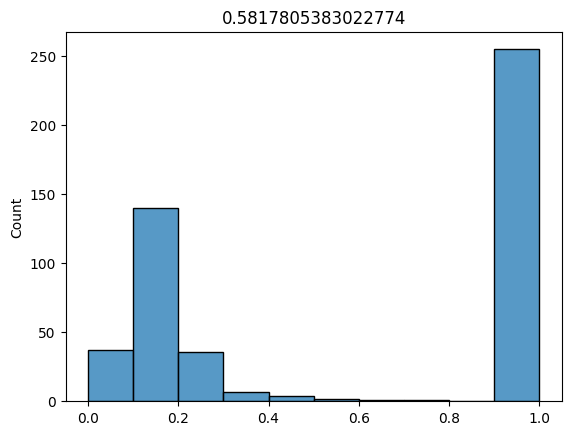

In [17]:
sns.histplot(ns12_metrics['frac_responsive_trials'].values)
plt.title(np.sum(ns12_metrics['frac_responsive_trials'].values > 0.25)/len(ns12_metrics))

<AxesSubplot: ylabel='Count'>

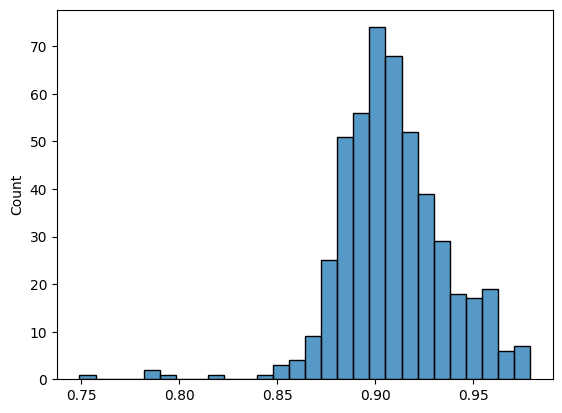

In [21]:
sns.histplot(ns12_metrics['lifetime_sparseness'].values)

Text(0.5, 1.0, '0.16977225672877846')

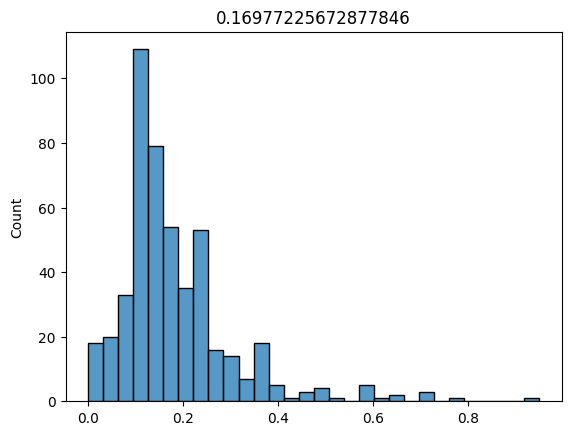

In [22]:
sns.histplot(ns12_metrics['frac_responsive_trials'].values)
plt.title(np.sum(ns12_metrics['frac_responsive_trials'].values > 0.25)/len(ns12_metrics))

In [46]:
dff_pref_img = ns12_metrics['pref_img'].values

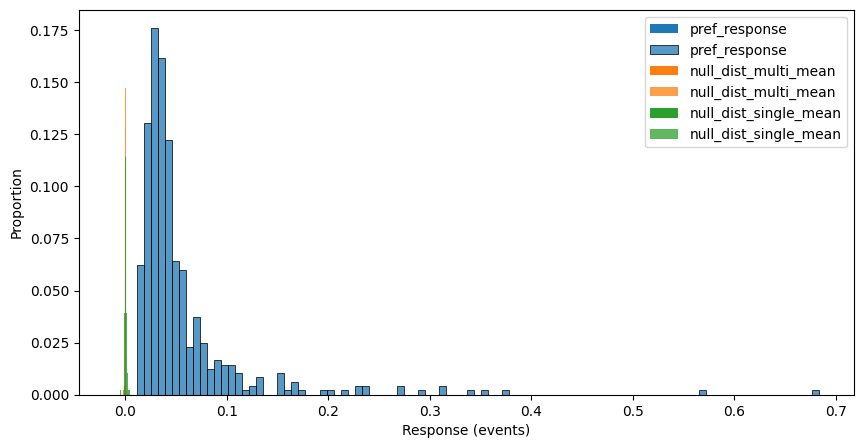

In [39]:
fig, ax = plt.subplots(figsize=(10,5))
sns.histplot(ns12_metrics['pref_response'],stat='proportion',label='pref_response')
sns.histplot(ns12_metrics['null_dist_multi_mean'],stat='proportion',label='null_dist_multi_mean')
sns.histplot(ns12_metrics['null_dist_single_mean'],stat='proportion',label='null_dist_single_mean')

ax.set_xlabel('Response (events)')
plt.legend()

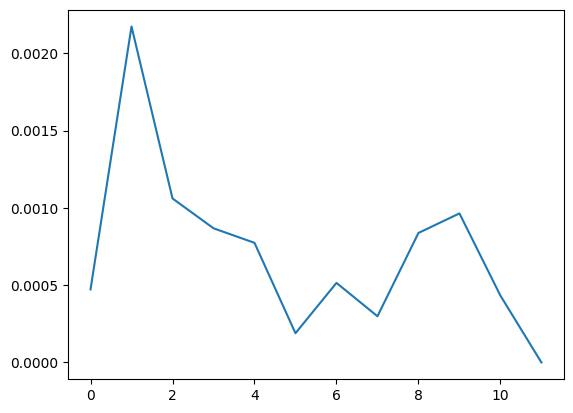

In [18]:
roi = 0
plt.plot(ns12_metrics.at[roi,'mean_responses'])

In [8]:
## Create stimulus object for natural scenes analysis
dgw = DriftingGratings(sess, 3, dg_type="windowed")

## Calculate standard single-cell metrics for natural scenes stimulus
dgw_metrics = dgw.metrics[dgw.is_roi_valid]


In [10]:
## Create stimulus object for natural scenes analysis
dgf = DriftingGratings(sess, 3, dg_type="full")

## Calculate standard single-cell metrics for natural scenes stimulus
dgf_metrics = dgf.metrics[dgf.is_roi_valid]

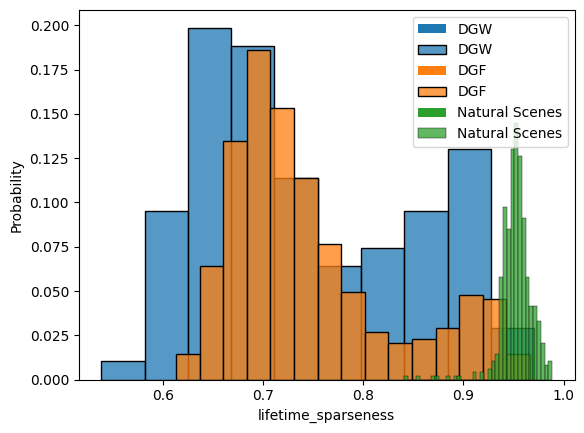

In [15]:
sns.histplot(dgw_metrics['lifetime_sparseness'],label='DGW',stat='probability')
sns.histplot(dgf_metrics['lifetime_sparseness'],label='DGF',stat='probability')

sns.histplot(ns12_metrics['lifetime_sparseness'],label='Natural Scenes',stat='probability')

plt.legend()


In [25]:
PSTH = np.stack(ns12_metrics['mean_responses'].values)
PSTH.shape


(483, 118)

<AxesSubplot: >

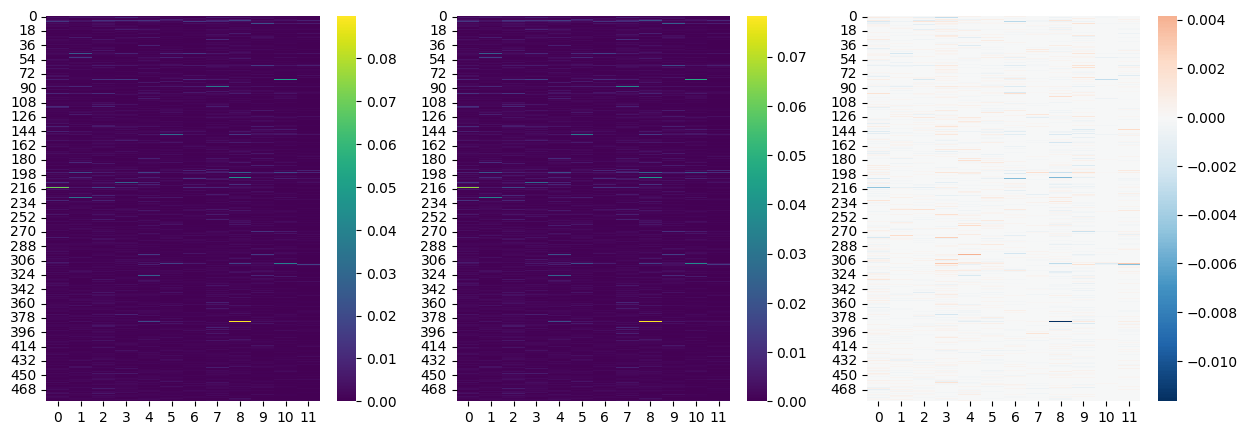

In [46]:
fig, axes = plt.subplots(1,3,figsize=(15,5))
sns.heatmap(PSTH_check,ax=axes[0],cmap='viridis')
sns.heatmap(PSTH,ax=axes[1],cmap='viridis')
sns.heatmap(PSTH - PSTH_check,ax=axes[2],cmap='RdBu_r',center=0)

Text(0.5, 1.0, '80 significant cells according to\n frac of trials compared to spont activity')

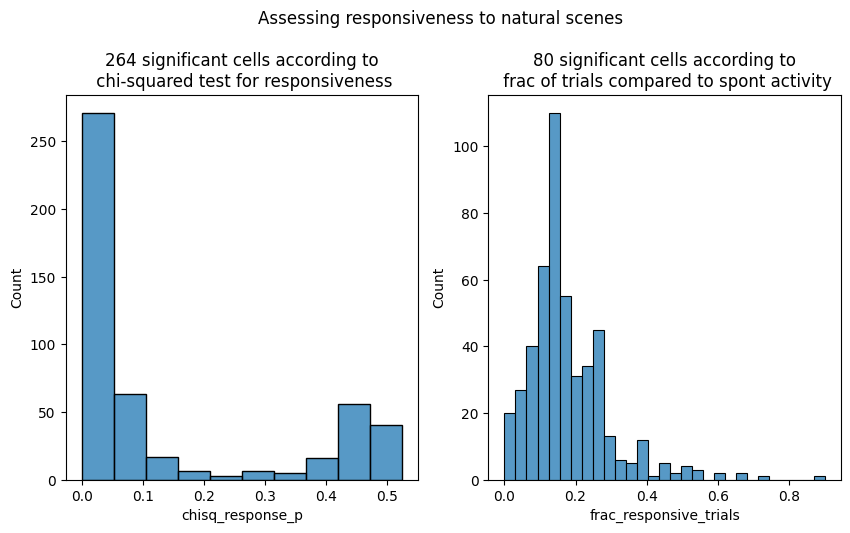

In [42]:
fig, axes = plt.subplots(1,2,figsize=(10,5))
plt.suptitle('Assessing responsiveness to natural scenes',y=1.05)
sns.histplot(ns12_metrics['chisq_response_p'],ax=axes[0])
axes[0].set_title('{} significant cells according to\n chi-squared test for responsiveness'.format(np.sum(ns12_metrics['chisq_response_p'] < 0.05)))


sns.histplot(ns12_metrics['frac_responsive_trials'])
axes[1].set_title('{} significant cells according to\n frac of trials compared to spont activity'.format(np.sum(ns12_metrics['frac_responsive_trials'] > 0.25)))


## Calculate natural image metrics on all sessions

In [23]:
mouse = 409828 # selected for EM
column = 1

session_ids = client.get_all_session_ids()
# session_ids = [s for s in session_ids if s.startswith(f"M{mouse}") and s[8] == str(column) and s[9] == "3"]
session_ids = [s for s in session_ids if s.startswith(f"M{mouse}") and s[8] == str(column)]

print("Sessions to load:")
print(session_ids)

Sessions to load:
['M409828_11', 'M409828_12', 'M409828_13', 'M409828_14', 'M409828_15', 'M409828_16', 'M409828_17', 'M409828_18', 'M409828_19', 'M409828_1a', 'M409828_1b', 'M409828_1c', 'M409828_1d', 'M409828_1e', 'M409828_1f']


In [24]:
sessions = []

for session_id in tqdm(session_ids):
    session = client.load_ophys_session(session_id=session_id)
    sessions.append(session)

print(f"Loaded {len(sessions)} ophys sessions")

  0%|          | 0/15 [00:00<?, ?it/s]

Loaded 15 ophys sessions


In [25]:
plane_info = [] # holds (mouse, column, volume, plane)
ns12_list = []
ns118_list = []

with tqdm(desc="Loading natural scene analyses", total=sum(len(s.get_planes()) for s in sessions)) as pbar:
    for session in sessions:
        for plane in session.get_planes():
            plane_info.append((session.get_mouse_id(), session.get_column_id(), session.get_volume_id(), plane))
            ns12_list.append(NaturalScenes(session, plane, ns_type="natural_images_12"))
            ns118_list.append(NaturalScenes(session, plane, ns_type="natural_images"))

            pbar.update()

Loading natural scene analyses:   0%|          | 0/40 [00:00<?, ?it/s]

In [26]:
for ns in ns12_list: ns._metrics = None
for ns in ns118_list: ns._metrics = None

# Concatenate across the different planes
print("Concatenating natural scene-12 metrics...")
ns12_metrics = StimulusAnalysis.concat_metrics(ns12_list)
print("Concatenating natural scene-118 metrics...")
ns118_metrics = StimulusAnalysis.concat_metrics(ns118_list)

Concatenating natural scene-12 metrics...
Concatenating natural scene-118 metrics...


In [4]:
DF_SAVE_DIR = r"/home/dwyrick/Git/v1dd_surround_suppression/dataframes"
ns118_metrics_file = path.join(DF_SAVE_DIR, "ns118_metrics_col_window0-4.csv")
ns12_metrics_file = path.join(DF_SAVE_DIR, "ns12_metrics_col_window0-4.csv")


ns118_metrics.to_csv(ns118_metrics_file)
ns12_metrics.to_csv(ns12_metrics_file)

In [28]:
print('Done')

Done


## Read in natural scene metrics

In [5]:
DF_SAVE_DIR = r"/home/dwyrick/Git/v1dd_surround_suppression/dataframes"
ns118_metrics_file = path.join(DF_SAVE_DIR, "ns118_metrics_col_window0-4.csv")
ns12_metrics_file = path.join(DF_SAVE_DIR, "ns12_metrics_col_window0-4.csv")

ns12_metrics = pd.read_csv(ns12_metrics_file, index_col=0, low_memory=False); ns12_metrics = ns12_metrics.loc[ns12_metrics.is_valid]
ns118_metrics = pd.read_csv(ns118_metrics_file, index_col=0, low_memory=False); ns118_metrics = ns118_metrics.loc[ns118_metrics.is_valid]
df_list = [ns12_metrics, ns118_metrics]

In [6]:
columns = ['mouse','column','volume','plane','roi','depth']
ns_metrics = ns12_metrics[columns]

columns = ['mean_responses','pref_response', 'pref_img', 'pref_img_idx', 'z_score',
       'z_score_responses', 'response_p', 'frac_responsive_trials',
       'lifetime_sparseness', 'p_trial_responses', 'sig_trial_responses',
       'norm_responses', 'is_valid', 'chisq_response_p',
       'null_dist_multi_mean', 'null_dist_multi_std', 'null_dist_single_mean',
       'null_dist_single_std']


for col in columns:
    for ii, type in enumerate(['ns12','ns118']):
        sub_df = df_list[ii]
        new_col = f'{type}_{col}'
        ns_metrics[new_col] = sub_df[col]

ns_metrics.to_csv(path.join(DF_SAVE_DIR, "ns_metrics_window0-4.csv"))

/tmp/ipykernel_1850384/3821380384.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ns_metrics[new_col] = sub_df[col]
/tmp/ipykernel_1850384/3821380384.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ns_metrics[new_col] = sub_df[col]
/tmp/ipykernel_1850384/3821380384.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

In [33]:
ns_metrics.loc['M409828_11_2_4']

mouse                                                                      409828
column                                                                          1
volume                                                                          1
plane                                                                           2
roi                                                                             4
depth                                                                          66
ns12_mean_responses             [0.0043565  0.00023809 0.00238015 0.01127938 0...
ns118_mean_responses            [0.00163609 0.00056146 0.         0.         0...
ns12_pref_response                                                       0.011279
ns118_pref_response                                                      0.023136
ns12_pref_img                                                                 6.0
ns118_pref_img                                                                6.0
ns12_pref_img_id

In [63]:
np.sum(ns12_metrics['frac_responsive_trials'].values > 0.25)/len(ns12_metrics)

0.36967263743051265

In [65]:
len(ns12_metrics)

9714

In [59]:
np.sum(ns118_metrics['frac_responsive_trials'].values > 0.25)/len(ns118_metrics)

0.6908585546633724

In [60]:
np.sum(metrics_df['dgw_frac_responsive_trials'].values > 0.25)/len(metrics_df)

0.44502779493514516

In [61]:
np.sum(metrics_df['dgf_frac_responsive_trials'].values > 0.25)/len(metrics_df)

0.5161622400658843